## Required Library

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

### Function 

In [2]:
def plot_auc_curve(model, X, y):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

## Preparing X and y

In [3]:
df = pd.read_csv('creditcard_dataset.csv') 
test = pd.read_csv('creditcard_test_dataset.csv') 
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,30808,109847,1.930307,-0.234417,-1.583368,0.024786,1.016470,1.179664,-0.386242,0.327416,...,-0.437585,0.211402,1.015098,0.073241,-0.804496,0.072202,-0.383211,0.016787,-0.081815,1.00
1,174948,84730,-5.053316,-3.617236,-0.323455,1.447171,-0.097495,-0.154917,-2.076441,1.331307,...,-1.351008,-0.202483,0.036442,-1.901898,0.090641,-1.777126,0.947972,0.954071,-1.577919,333.48
2,203982,95957,0.090684,1.197902,-1.370219,0.770437,0.857203,-0.698486,1.350617,-0.952780,...,0.617074,-0.255027,0.378177,-0.126596,0.572250,0.347829,0.538705,-0.211582,-0.267241,50.14
3,283146,142109,1.808668,-1.197522,-2.291089,-0.690236,-0.312654,-1.756994,0.631548,-0.725965,...,0.457894,0.498576,0.927097,-0.283918,0.134011,0.372327,0.050185,-0.121994,-0.038088,254.04
4,47316,129034,-0.920372,1.003867,-0.110709,-2.771173,0.841827,-0.497278,0.769851,0.474075,...,-0.175248,-0.238352,-0.849203,-0.124786,0.086646,-0.007944,0.360582,0.090110,0.091000,1.00


In [4]:
df.isnull().sum()

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Text(0.5, 0, 'Class')

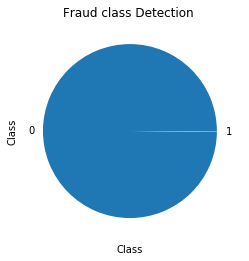

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'pie')
plt.title("Fraud class Detection ")
plt.xlabel("Class")

In [6]:
df.shape

(244807, 32)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']].values.reshape(-1, 2))
test[['Time', 'Amount']] = scaler.fit_transform(test[['Time', 'Amount']].values.reshape(-1, 2))

In [9]:
X = df.iloc[:, 1:31]
y = df.iloc[:, -1]

Xtest = test.iloc[:, 1:31]
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.760285,-0.854092,0.644458,1.805656,1.146369,-0.519127,1.844676,-0.935942,1.056104,0.097375,...,-0.152801,0.193673,0.789467,0.218834,-0.577043,-0.727521,0.612977,-0.219109,-0.063157,-0.306075
1,1.462703,-0.863534,0.291699,0.594479,-1.190707,0.117851,0.169880,0.065587,0.289947,-1.748278,...,-0.399149,-0.223345,-0.333300,-0.455269,0.185385,0.432974,0.931127,-0.414413,-0.284978,-0.250542
2,-1.178903,-1.192107,-0.896044,1.204410,-1.593935,0.432699,-1.101769,-0.299815,0.222793,-1.320361,...,0.422365,0.470749,0.932440,0.159099,0.215700,-0.169315,-0.320951,0.310243,0.210535,-0.117575
3,-1.982275,-2.355336,2.316182,0.701735,0.174501,0.677346,1.029705,0.792868,-0.060581,1.296525,...,0.972466,0.008872,0.955806,0.047292,-0.650140,-0.282282,-0.286391,0.335493,0.223061,-0.340423
4,-0.910943,-1.302336,1.016359,1.007046,-0.127051,0.435740,-0.092143,0.709650,0.590142,-1.088295,...,-0.174480,0.150091,0.059446,-0.262177,-0.354871,0.680078,-0.402172,-0.111834,-0.044427,-0.146139


## Split Method

In [10]:
# 1. Use cross-validation

X1_train, X1_test, y1_train, y1_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.05,
                                                    random_state = 1)

In [11]:
LR = LogisticRegression()
LR.fit(X1_train, y1_train)
y1_pred = LR.predict(X1_test)
y1_pred_prob = LR.predict_proba(X1_test)[:,1]

[accuracy_score(y1_test, y1_pred), roc_auc_score(y1_test, y1_pred_prob), log_loss(y1_test, y1_pred_prob)]

[0.9991013806061596, 0.9619928514910917, 0.006164278399536513]

In [20]:
confusion_matrix(y1_test , y1_pred)

array([[12214,     3],
       [    8,    16]])

In [12]:
# 2. StratifiedShuffleSplit (Folds are made by preserving the percentage of samples for each class)

split = StratifiedShuffleSplit(n_splits=10, test_size=0.05, train_size=0.95, random_state=0)

for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

In [13]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
y_pred_prob = LR.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9993464586226616, 0.988293975528018, 0.0038022930099709104]

In [16]:
confusion_matrix(y_test , y_pred)

array([[12217,     3],
       [    9,    12]])

## Model Selection

In [23]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.1, train_size=0.85, random_state=0)


model = [LogisticRegression(),
         RandomForestClassifier(),
         AdaBoostClassifier(),
         GradientBoostingClassifier()]

res = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC', 'LogLoss'])
j=0

for classifier in model:
    accu, auc, logloss = [], [], []
    print(classifier.__class__.__name__)
    i=0
    
    for train_idx, test_idx in split.split(X, y):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]
    
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_pred_prob = classifier.predict_proba(X_test)[:,1]
        
        accu.append(accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred_prob))
        logloss.append(log_loss(y_test, y_pred_prob))
        
        i=i+1
        print(i)
        
    res.loc[j, 'Model'] = classifier.__class__.__name__
    res.loc[j, 'Accuracy'] = np.mean(accu)
    res.loc[j, 'AUC'] = np.mean(auc)
    res.loc[j, 'LogLoss'] = np.mean(logloss)
    j += 1    
res

LogisticRegression
1
2
3
4
5
RandomForestClassifier
1
2
3
4
5
AdaBoostClassifier
1
2
3
4
5
GradientBoostingClassifier
1
2
3
4
5


,Model,Accuracy,AUC,LogLoss
0,LogisticRegression,0.999273,0.975723,0.00382113
1,RandomForestClassifier,0.999543,0.932971,0.00942567
2,AdaBoostClassifier,0.999281,0.967043,0.52118
3,GradientBoostingClassifier,0.998775,0.498512,0.0326725


In [58]:
split = StratifiedShuffleSplit(n_splits=10, test_size=0.25, train_size=0.7, random_state=0)

for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

#### SVM

In [30]:
# SVM 1

SVM = SVC(probability=True,C=1.0)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
y_pred_prob = SVM.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9995506719496753, 0.9536231121606955, 0.0027405832854728845]

In [31]:
# SVM 2

SVM = SVC(probability=True, class_weight ={1:2},C=1.0)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
y_pred_prob = SVM.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9995915199542502, 0.9578737342148284, 0.0024039411766273895]

In [32]:
# SVM 3

SVM = SVC(probability=True, class_weight ={1:3},C=1.0)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
y_pred_prob = SVM.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9995506719496753, 0.9568098608975896, 0.002438261075312757]

In [33]:
# SVM 5

SVM = SVC(probability=True, class_weight ={1:5},C=1.0)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
y_pred_prob = SVM.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9995506719496753, 0.9577402629286912, 0.0025177308299234834]

In [34]:
# SVM balanced

SVM = SVC(probability=True, class_weight ='balanced',C=1.0)
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
y_pred_prob = SVM.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9963236795882521, 0.9737558430221795, 0.004708499683125423]

In [35]:
confusion_matrix(y_test, y_pred)

array([[24357,    82],
       [    8,    34]])

In [85]:
y_predict=SVM.predict(Xtest)
y_predict_proba=SVM.predict_proba(Xtest)
SVM3=pd.DataFrame({'id':test['id'],'Class':y_predict})
SVM3.to_csv('SVM3.csv',index=False,sep=',')

#### Logistic Regression

#### Fit Logistic regression with L1 regularization (Lasso)

In [59]:
# Logistic Regression  Weight=1:1

LR1 = LogisticRegression(penalty='l1')
LR1.fit(X_train, y_train)
y_pred = LR1.predict(X_test)
y_pred_prob = LR1.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.999183033234208, 0.9690195263377648, 0.004048201735905306]

In [60]:
confusion_matrix(y_test, y_pred)

array([[61088,     8],
       [   42,    64]])

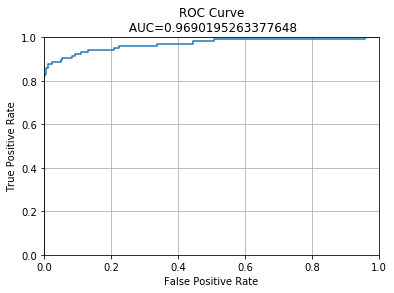

In [61]:
plot_auc_curve(LR1, X_test, y_test)

In [62]:
# Logistic Regression  Weight=7:3

LR2 = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight={0:0.3, 1:0.7}, random_state=None, solver='lbfgs', max_iter=100, multi_class='warn', 
                        verbose=0, warm_start=False, n_jobs=None)
LR2.fit(X_train, y_train)
y_pred = LR2.predict(X_test)
y_pred_prob = LR2.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.999281069246103, 0.971666767549245, 0.0040827820006948895]

In [63]:
confusion_matrix(y_test, y_pred)

array([[61080,    16],
       [   28,    78]])

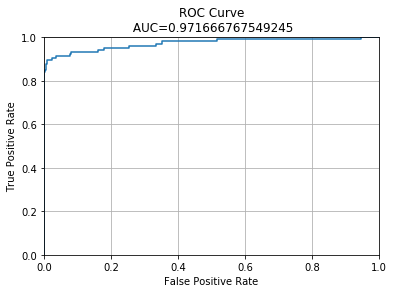

In [64]:
plot_auc_curve(LR2, X_test, y_test)

In [65]:
# Logistic Regression  Weight=3:1

LR3 = LogisticRegression(penalty='l1',class_weight={1:3})
LR3.fit(X_train, y_train)
y_pred = LR3.predict(X_test)
y_pred_prob = LR3.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9992974085814189, 0.9713724580678476, 0.004265685116789128]

In [66]:
confusion_matrix(y_test, y_pred)

array([[61080,    16],
       [   27,    79]])

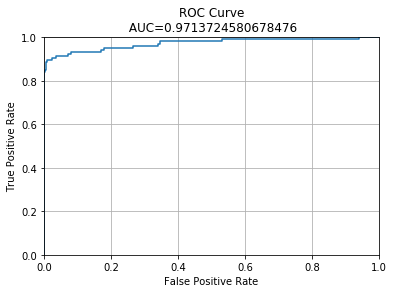

In [67]:
plot_auc_curve(LR3, X_test, y_test)

In [68]:
# Logistic Regression  Weight=5:1

LR4 = LogisticRegression(penalty='l1',class_weight={1:5})
LR4.fit(X_train, y_train)
y_pred = LR4.predict(X_test)
y_pred_prob = LR4.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9992974085814189, 0.9708661407596089, 0.0048878398186192554]

In [69]:
confusion_matrix(y_test, y_pred)

array([[61076,    20],
       [   23,    83]])

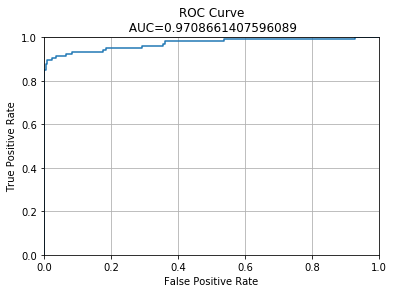

In [70]:
plot_auc_curve(LR4, X_test, y_test)

In [71]:
# Logistic Regression  solver = 'sag'

LR5 = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight={0:0.275, 1:0.725}, random_state=None, solver='sag', max_iter=100, multi_class='warn', 
                        verbose=0, warm_start=False, n_jobs=None)
LR5.fit(X_train, y_train)
y_pred = LR5.predict(X_test)
y_pred_prob = LR5.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9994444625992615, 0.9781387967220162, 0.006176502043768645]

In [72]:
confusion_matrix(y_test, y_pred)

array([[61089,     7],
       [   27,    79]])

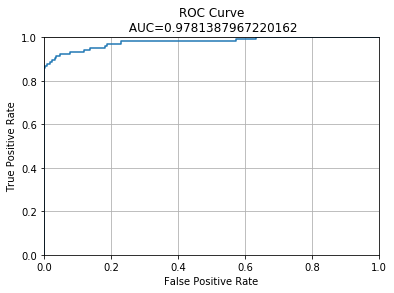

In [73]:
plot_auc_curve(LR5, X_test, y_test)

In [74]:
# Logistic Regression  solver = 'liblinear'

LR6 = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight={0:0.275, 1:0.725}, random_state=None, solver='liblinear', max_iter=100, multi_class='warn', 
                        verbose=0, warm_start=False, n_jobs=None)
LR6.fit(X_train, y_train)
y_pred = LR6.predict(X_test)
y_pred_prob = LR6.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9992974085814189, 0.9726780124567336, 0.0042370328862791915]

In [75]:
confusion_matrix(y_test, y_pred)

array([[61080,    16],
       [   27,    79]])

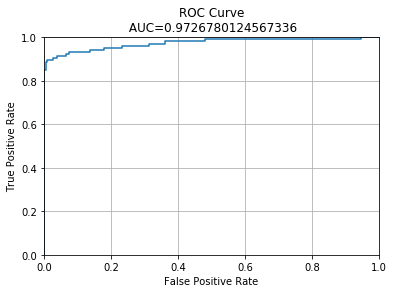

In [76]:
plot_auc_curve(LR6, X_test, y_test)

In [77]:
# Logistic Regression  Weight='balanced'

LR_balanced = LogisticRegression(class_weight='balanced')
LR_balanced.fit(X_train, y_train)
y_pred = LR_balanced.predict(X_test)
y_pred_prob = LR_balanced.predict_proba(X_test)[:,1]

[accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob), log_loss(y_test, y_pred_prob)]

[0.9744942975719748, 0.9704861325572374, 0.11089925806088492]

In [78]:
confusion_matrix(y_test, y_pred)

array([[59547,  1549],
       [   12,    94]])

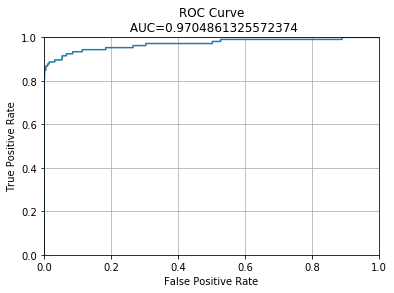

In [79]:
plot_auc_curve(LR_balanced, X_test, y_test)

### Feature Selection

In [29]:
weights = LR2.coef_ 
abs_weights = np.abs(weights)

print(abs_weights)

[[0.25283051 0.08582673 0.01166216 0.0196452  0.66074164 0.12075318
  0.1568368  0.08150357 0.21218139 0.26194676 0.65296999 0.06910744
  0.18893289 0.40563967 0.53226772 0.16935024 0.20285333 0.05174748
  0.01776358 0.09752859 0.35395606 0.32792756 0.59373887 0.10808142
  0.16451911 0.12212405 0.10199645 0.54182703 0.17438424 0.19112723]]


In [32]:
selector = RFE(LR1, 5, step=1)
selector = selector.fit(X_train, y_train)

In [33]:
selector.ranking_

array([12, 19, 24, 23,  1, 16,  9, 18,  4,  6,  2, 22, 21,  1,  1, 13,  3,
       20, 26, 14,  8,  1,  1,  5, 15, 11, 25,  7, 10, 17])

In [34]:
selector.support_

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False])

In [80]:
pre= LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight={1:3}, random_state=None, solver='lbfgs', max_iter=100, multi_class='warn', 
                        verbose=0, warm_start=False, n_jobs=None)
pre.fit(X,y)
y_predict=pre.predict(Xtest)
y_predict_proba=LR2.predict_proba(Xtest)[:,1]

In [81]:
submission=pd.DataFrame({'id':test['id'],'Probability':y_predict_proba})
submission.to_csv('Final_result.csv',index=False,sep=',')